In [1]:
import os
import sys
import pandas as pd
import seaborn as sns
import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

# Read log files

In [2]:
directory = '../../capturec_mo/asmith_pipeline/stats/'

# Initial duplication statistics

In [3]:
df = pd.read_csv(directory + 'deduplication_stats.tsv', sep='\t', index_col=0)
df

,Read_pairs_processed,Read_pairs_unique,Read_pairs_removed
ABM_S1_comb,16884018,11264716,5619302


In [4]:
df_melt = (df.reset_index()
             .drop(columns='Read_pairs_processed')
             .melt(id_vars=['index'], var_name='stat', value_name='count')
             .rename(columns={'index': 'sample'})
             .assign(sample=lambda df: df['sample']))
(alt.Chart(df_melt)
    .mark_bar()
    .encode(x='count',
            y='sample',
            color='stat'))

alt.Chart(...)

# Read pair combination statistics

In [5]:
df = pd.read_csv(directory + 'combined_stats.tsv', sep='\t', index_col=0)
df = df.loc[lambda df: df['stat_type'].isin(['Flashed or unflashed'])]
df

,sample,read_type,stat_type,read_pairs
4,ABM_S1_comb,flashed,Flashed or unflashed,9036457.0
5,ABM_S1_comb,pe,Flashed or unflashed,423651.0


In [6]:
(alt.Chart(df)
    .mark_bar()
    .encode(x='read_pairs',
            y='sample',
            color='read_type'))

alt.Chart(...)

# Fastq *in silico* digestion statistics

In [13]:
df = pd.read_csv(directory + 'digestion_stats.tsv', sep='\t', index_col=0)

In [14]:
df['n_slices'] = df['frequency'] * df['bin']
df_summarise = (df.groupby(['sample', 'read_type', 'stat'])
                  ['n_slices']
                  .sum()
                  .reset_index()
                  .assign(read_type=lambda df: df['read_type'].str.replace('r1', 'read_1').str.replace('r2', 'read_2')))

print('Total vs Valid slices (in silico digested read pairs)')
(alt.Chart(df_summarise)
    .mark_bar()
    .encode(x='n_slices',
            y='stat',
            color='read_type',
            row='sample'))

Total vs Valid slices (in silico digested read pairs)


alt.Chart(...)

In [15]:
df_hist = (df.loc[lambda df: df['stat'] == 'valid']
             [['sample', 'bin', 'read_type', 'frequency']]
             .assign(log10_count=lambda df: np.log10(df['frequency'] + 1e-12),
                     read_type=lambda df: df['read_type'].str.replace('r1', 'read_1').str.replace('r2', 'read_2'))
          )

(alt.Chart(df_hist)
    .mark_bar()
    .encode(x='bin:N',
            y='log10_count',
            color='read_type',
            row='sample',
            )
)

alt.Chart(...)

# CCanalyser_statistics

In [16]:
df = pd.read_csv(directory + 'ccanalyser_stats.tsv', sep='\t', index_col=0)
# split = (df.reset_index()
#            ['index']
#            .str.split('|', expand=True)
#            .rename(columns={}))

#df = pd.concat([df.reset_index(), split], axis=1, ignore_index=True)

In [17]:
df = df.reset_index().rename(columns={'index': 'filtering_step'})
df['filtering_step'] = df['filtering_step'].str.replace('|', ' ')
#df.columns = df.columns.str.capitalize().str.replace('_', ' ')
df

,filtering_step,mapped,multimapping_slices,number_of_capture_slices,number_of_slices_in_blacklisted_region,number_of_slices_in_exclusion_region,unique_capture_sites,unique_fragments,unique_slices
0,ABM_S1_comb flashed mapped,6601788,0,1311685,0,161198,6,3848202,6584037
1,ABM_S1_comb flashed contains_single_capture,1885671,0,938033,0,143318,6,927822,1883896
2,ABM_S1_comb flashed contains_capture_and_reporter,1583788,0,779468,0,0,6,778583,1582174
3,ABM_S1_comb flashed duplicate_filtered,1525541,0,750373,0,0,6,750372,1523975
4,ABM_S1_comb pe mapped,260720,0,52922,0,4236,6,160812,259313
5,ABM_S1_comb pe contains_single_capture,43638,0,23695,0,3071,6,16904,43444
6,ABM_S1_comb pe contains_capture_and_reporter,32688,0,15824,0,0,6,12327,32558
7,ABM_S1_comb pe duplicate_filtered,24345,0,11631,0,0,6,11594,24224


## Capture and reporter statistics

In [22]:
df = pd.read_csv(f'{directory}/reporter_stats.tsv', sep='\t', index_col=0)
df = df.groupby(['sample','capture_probe', 'cis/trans']).sum().reset_index()
df

,sample,capture_probe,cis/trans,count
0,ABM_S1_comb,Hba-1,cis,110214
1,ABM_S1_comb,Hba-1,trans,65699
2,ABM_S1_comb,Hba-2,cis,107907
3,ABM_S1_comb,Hba-2,trans,62957
4,ABM_S1_comb,Hbb-b1,cis,70441
5,ABM_S1_comb,Hbb-b1,trans,49103
6,ABM_S1_comb,Hbb-b2,cis,96830
7,ABM_S1_comb,Hbb-b2,trans,67776
8,ABM_S1_comb,Slc25A37,cis,98302
9,ABM_S1_comb,Slc25A37,trans,58704


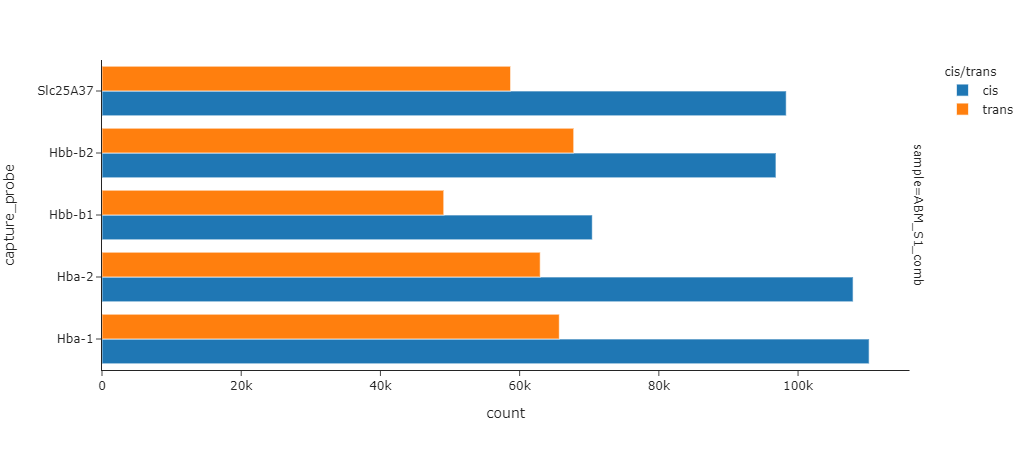

In [26]:
px.bar(data_frame=df,
       x='count',
       y='capture_probe',
       color='cis/trans',
       facet_row='sample',
       barmode='group',
       template='simple_white')

# Overall stats

In [17]:
df = pd.read_csv(directory + 'combined_stats.tsv', sep='\t', index_col=0)
(alt.Chart(df)
    .mark_bar()
    .encode(x='read_pairs',
            y=alt.Y('stat_type', sort=None),
            color='read_type',
            order=alt.Order('read_type', sort='ascending'),
            row='sample')
    .interactive()
)

alt.Chart(...)